# Spatial Domain Filters
Here we will show:
* How to implement 2D convolution for smoothing and filtering
* Design of Low, High, and Band-pass filters

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
im_apollo11 = cv2.imread(os.path.relpath('../../Data/Apollo_11_Launch.jpg'), cv2.IMREAD_GRAYSCALE)

Text(0.5, 1.0, 'Smoothed 7x7 Median')

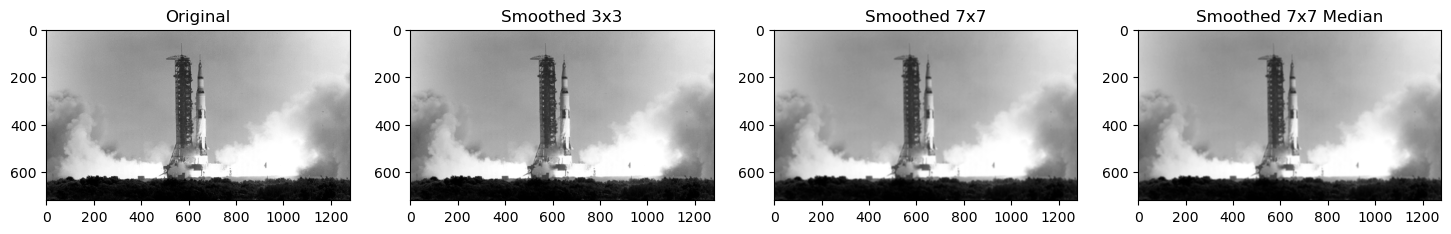

In [10]:
# Filters in the spatial domain are just convolutions with a kernel

# Easiest low pass we can make
kernel1 = np.ones([3, 3])/9 
kernel2 = np.ones([7, 7])/49 # Note,we want the sum to be 1 to preserve the oiginal scale of the image

im_apollo11_smoothed1 = cv2.filter2D(im_apollo11,-1,kernel1)
im_apollo11_smoothed2 = cv2.filter2D(im_apollo11,-1,kernel2)


# Instead of the mean filters we just used, let's show a center replacement filter.
# This filter has a hole in center. The value of the pixel at the anchor is replaced with the mean of the values around it
# This type filter is good for removing dust.  

kernel3 = np.ones([7, 7])/48 # Note,we want the sum to be 1 to preserve the oiginal scale of the image
kernel3[3,3]=0

# Since our image doesn't really have dust, you probably won't see any difference, but this is how it works
im_apollo11_smoothed3 = cv2.filter2D(im_apollo11,-1,kernel3)



# Show the images
plt.figure(figsize=[18, 5])
plt.subplot(141);plt.imshow(im_apollo11,cmap='gray');  plt.title("Original")
plt.subplot(142);plt.imshow(im_apollo11_smoothed1,cmap='gray');  plt.title("Smoothed 3x3")
plt.subplot(143);plt.imshow(im_apollo11_smoothed2,cmap='gray');  plt.title("Smoothed 7x7")
plt.subplot(144);plt.imshow(im_apollo11_smoothed3,cmap='gray');  plt.title("Smoothed 7x7 center-removed")


## Windowed FIR method
 In the Frequency-domain filtering notebook, we multiplied by top-hat functions in the Fourier domain and then iDFT back
 This would be the same as convolving the image with the iFFT of the top-hat function.  However the iFFT of the top-hat function would 
 have infinite support and this kernel would be very large.  Therefore, we taper the iFFT(top-hat) down using a window to give it a finite kernel size. 

 The iFFT of a top-hat is a 2D SINC function.  
 * Low  pass: $$ K[r] = \frac{sin(r*f_c)}{\pi*r} \qquad   \lim_{r \to 0} =\frac{f_c}{\pi} $$
 * High pass: $$ K[r] = \frac{-sin(r*f_c)}{\pi*r} \qquad   \lim_{r \to 0} =1-\frac{f_c}{\pi} $$
 * Band pass: $$ K[r] = \frac{-sin(r*f_{high})}{\pi*r}-\frac{-sin(r*f_{low})}{\pi*r} \qquad   \lim_{r \to 0} =\frac{f_{high}-f_{low}}{\pi} $$
 * Notch pass: $$ K[r] = \frac{-sin(r*f_{low})}{\pi*r}-\frac{-sin(r*f_{high})}{\pi*r} \qquad   \lim_{r \to 0} =1-\frac{f_{high}-f_{low}}{\pi} $$

 

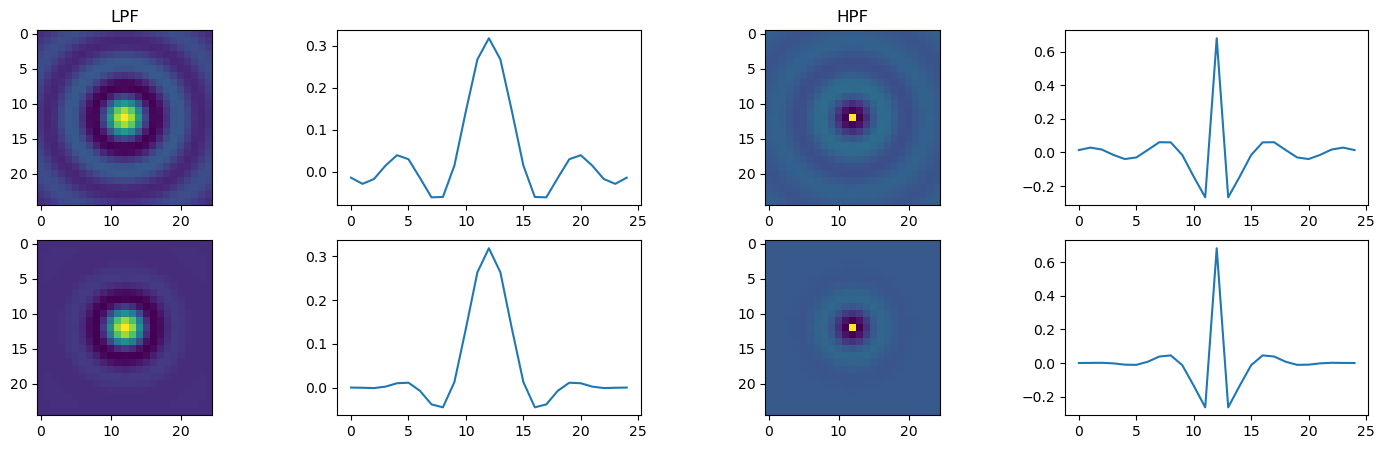

In [70]:
x, y = np.indices([25,25])  # Let's use a 25 x 25 kernel

x=x-12; y=y-12; # Now [0,0] is the center
r = np.sqrt(x**2+y**2)

# in all the equations, they have to be dealt with as r--> 0 because it would be a divide by zero issue
r[12,12]=1 # mask it for now

fc = 1
kernel_FIR_LPF = np.sin(r*fc)/(np.pi*r)
kernel_FIR_LPF[12,12]=fc/np.pi

kernel_FIR_HPF = -np.sin(r*fc)/(np.pi*r)
kernel_FIR_HPF[12,12]=1-fc/np.pi

# These kernels will have discontinuities at the edges (don't go to 0 in the 25x25 kernel)
# So we need to window these to drop to zero to avoid ringing artifacts

# Make a 2D hanning window
win = np.outer(np.hanning(25),np.hanning(25))

kernel_FIR_LPF_win=kernel_FIR_LPF*win
kernel_FIR_HPF_win=kernel_FIR_HPF*win


plt.figure(figsize=[18, 5])
plt.subplot(241); plt.imshow(kernel_FIR_LPF); plt.title("LPF") 
plt.subplot(242); plt.plot(kernel_FIR_LPF[:,12])
plt.subplot(243); plt.imshow(kernel_FIR_HPF); plt.title("HPF") 
plt.subplot(244); plt.plot(kernel_FIR_HPF[:,12])
plt.subplot(245); plt.imshow(kernel_FIR_LPF_win)
plt.subplot(246); plt.plot(kernel_FIR_LPF_win[:,12])
plt.subplot(247); plt.imshow(kernel_FIR_HPF_win)
plt.subplot(248); plt.plot(kernel_FIR_HPF_win[:,12])

Text(0.5, 1.0, 'High Pass FIR (windowed)')

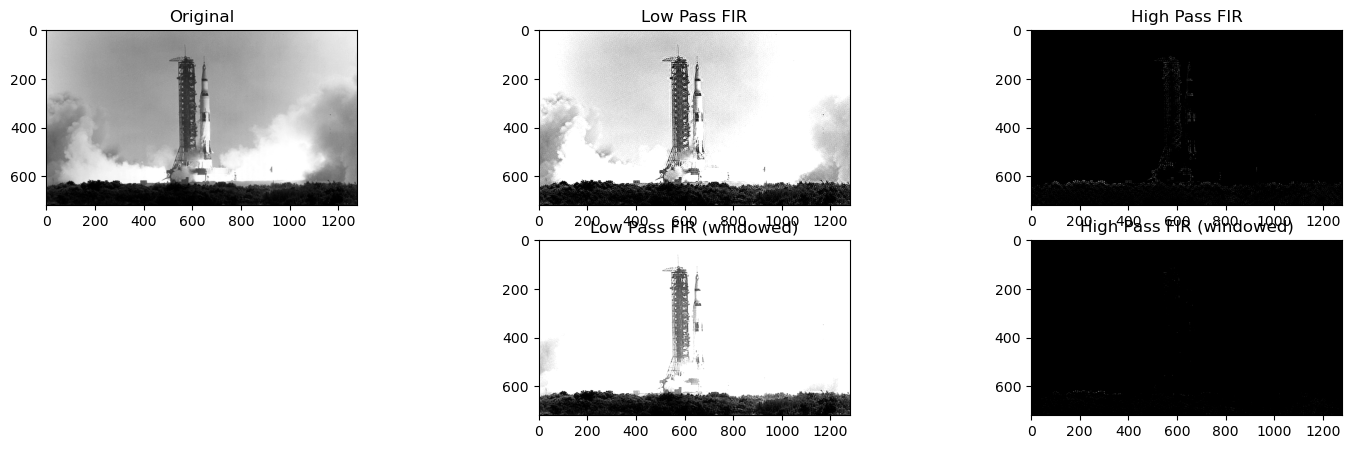

In [71]:
im_apollo11_fir_LPF = cv2.filter2D(im_apollo11,-1,kernel_FIR_LPF)
im_apollo11_fir_HPF = cv2.filter2D(im_apollo11,-1,kernel_FIR_HPF)

im_apollo11_fir_LPF_win = cv2.filter2D(im_apollo11,-1,kernel_FIR_LPF_win)
im_apollo11_fir_HPF_win = cv2.filter2D(im_apollo11,-1,kernel_FIR_HPF_win)


# Show the images
plt.figure(figsize=[18, 5])
plt.subplot(231);plt.imshow(im_apollo11,cmap='gray');  plt.title("Original")
plt.subplot(232);plt.imshow(im_apollo11_fir_LPF,cmap='gray');  plt.title("Low Pass FIR")
plt.subplot(233);plt.imshow(im_apollo11_fir_HPF,cmap='gray');  plt.title("High Pass FIR")
plt.subplot(235);plt.imshow(im_apollo11_fir_LPF_win,cmap='gray');  plt.title("Low Pass FIR (windowed)")
plt.subplot(236);plt.imshow(im_apollo11_fir_HPF_win,cmap='gray');  plt.title("High Pass FIR (windowed)")